Variational Autoencoder
==================

In [1]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall
#%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms, datasets
from scipy.stats import norm
%matplotlib inline

In [3]:
#######Just downloading the whole dataset and also creating batches

train_transform = transforms.Compose([transforms.ToTensor()])

trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=500, shuffle=True)

100%|██████████| 9912422/9912422 [00:05<00:00, 1840462.10it/s]


Extracting C:\Users\52333/.pytorch/MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to C:\Users\52333/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28910666.78it/s]


Extracting C:\Users\52333/.pytorch/MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\52333/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 1955343.45it/s]


Extracting C:\Users\52333/.pytorch/MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\52333/.pytorch/MNIST_data/MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4536920.40it/s]

Extracting C:\Users\52333/.pytorch/MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\52333/.pytorch/MNIST_data/MNIST\raw



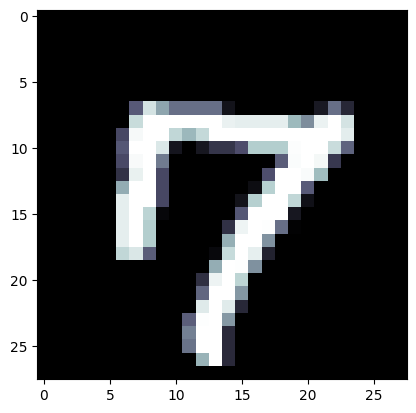

In [4]:
######## Just checking out what the dataset looks like
dataiter = iter(trainloader)
images, labels = dataiter.__next__()  # Utiliza __next__() en lugar de next()
images.shape
plt.imshow(images[32].squeeze().numpy(), cmap='bone')

In [5]:
########Definition of the architecture of our encoder and decoder model with all the assisting functions

class Net(nn.Module):
    def __init__(self, num_latent):
        super().__init__()
        
        #Those are the layers for the encoder part
        self.encoder = nn.Sequential(nn.Conv2d(1, 3, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(3),
                                     nn.Conv2d(3, 16, 3, padding=1),
                                     nn.MaxPool2d(2, 2),
                                     nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1))
        
        #the bottleneck part
        #These two layers are for getting logvar and mean
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        #out two vector of random variables
        self.mean = nn.Linear(128, num_latent) 
        self.var = nn.Linear(128, num_latent)
        #they provide a vector that is a random sample that passes to the decoder

        #######The decoder part
        #This is the first layer for the decoder part
        self.expand = nn.Linear(num_latent, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 784)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(16, 16, 3, padding=1),
                                     nn.BatchNorm2d(16),
                                     nn.ConvTranspose2d(16, 3, 8),
                                     nn.BatchNorm2d(3),
                                     nn.ConvTranspose2d(3, 1, 15))
        
    def enc_func(self, x):
        #here we will be returning the logvar(log variance) and mean of our network
        x = self.encoder(x) #we call the encoder layer
        x = x.view([-1, 784])
        x = F.dropout2d(self.fc1(x), 0.5)
        x = self.fc2(x)
        
        mean = self.mean(x) 
        logvar = self.var(x)
        return mean, logvar
    
    def dec_func(self, z):
        #here z is the latent variable state
        z = self.expand(z)
        z = F.dropout2d(self.fc3(z), 0.5)
        z = self.fc4(z)
        z = z.view([-1, 16, 7, 7])
        
        out = self.decoder(z)
        out = F.sigmoid(out)
        return out
    
    def get_hidden(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)   #standard deviation
            noise = torch.randn_like(mean)   #So as to get the noise of standard distribution. It could be other random number
            return noise.mul(std).add_(mean)
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.enc_func(x)
        z = self.get_hidden(mean, logvar)
        out = self.dec_func(z)
        return out, mean, logvar

In [6]:
#######This is the custom loss function defined for VAE
### Kullback- Leibler divergence which meassures the difference between two probability distributions

def VAE_loss(out, target, mean, logvar):
    category1 = nn.BCELoss()
    bce_loss = category1(out, target)
    
    #We will scale the following losses with this factor
    scaling_factor = out.shape[0]*out.shape[1]*out.shape[2]*out.shape[3]
    
    ####Now we are gonna define the KL divergence loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mean**2 - torch.exp(logvar))
    kl_loss /= scaling_factor
    
    return bce_loss + kl_loss

In [7]:
######The function which we will call for training our model

def train(trainloader, iters, model, device, optimizer, print_every):
    counter = 0
    for i in range(iters):
        model.train()
        model.to(device)
        for images, _ in trainloader:
            images = images.to(device)
            optimizer.zero_grad()
            out, mean, logvar = model(images)
            loss = VAE_loss(out, images, mean, logvar)
            loss.backward()
            optimizer.step()
            
        if(counter % print_every == 0):
            model.eval()
            n = 10  # figure with 20x20 digits
            digit_size = 28
            figure = np.zeros((digit_size * n, digit_size * n))

            # Construct grid of latent variable values
            grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
            grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

            counter = 0
            # decode for each square in the grid
            for i, yi in enumerate(grid_x):
                for j, xi in enumerate(grid_y):
                    digit = out[counter].squeeze().cpu().detach().numpy()
                    figure[i * digit_size: (i + 1) * digit_size,
                           j * digit_size: (j + 1) * digit_size] = digit
                    counter += 1

            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='bone')
            plt.show()  

        counter += 1

cuda


c:\Users\52333\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


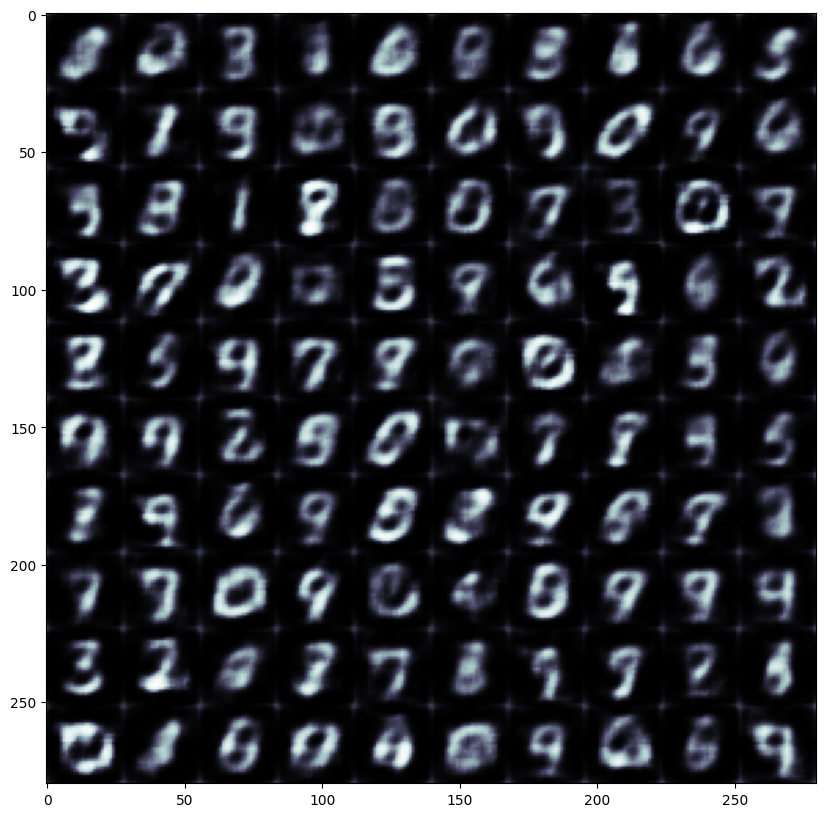

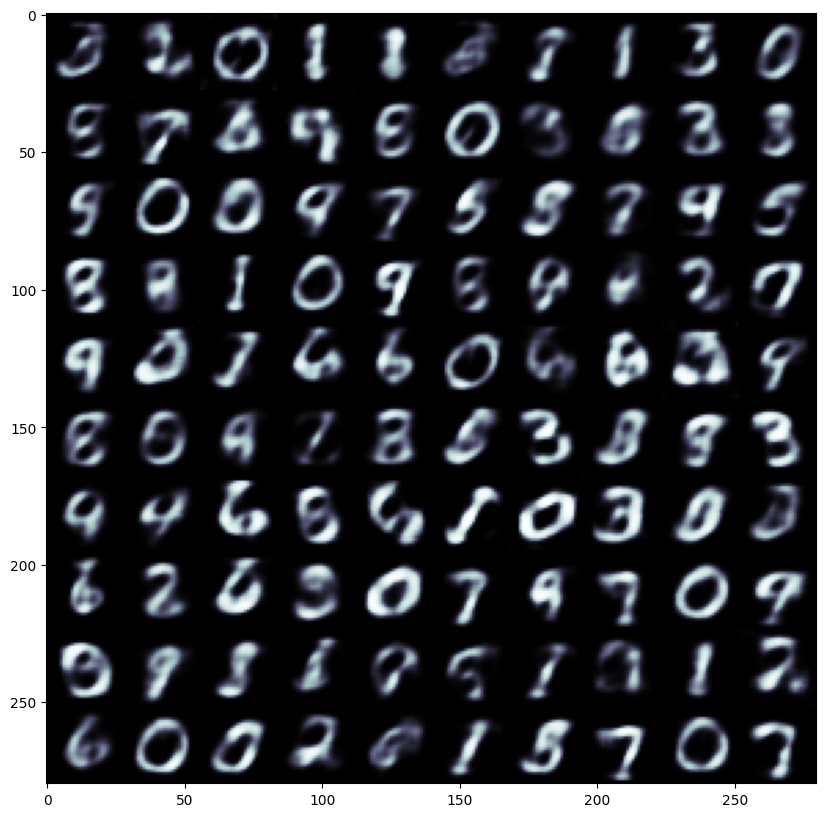

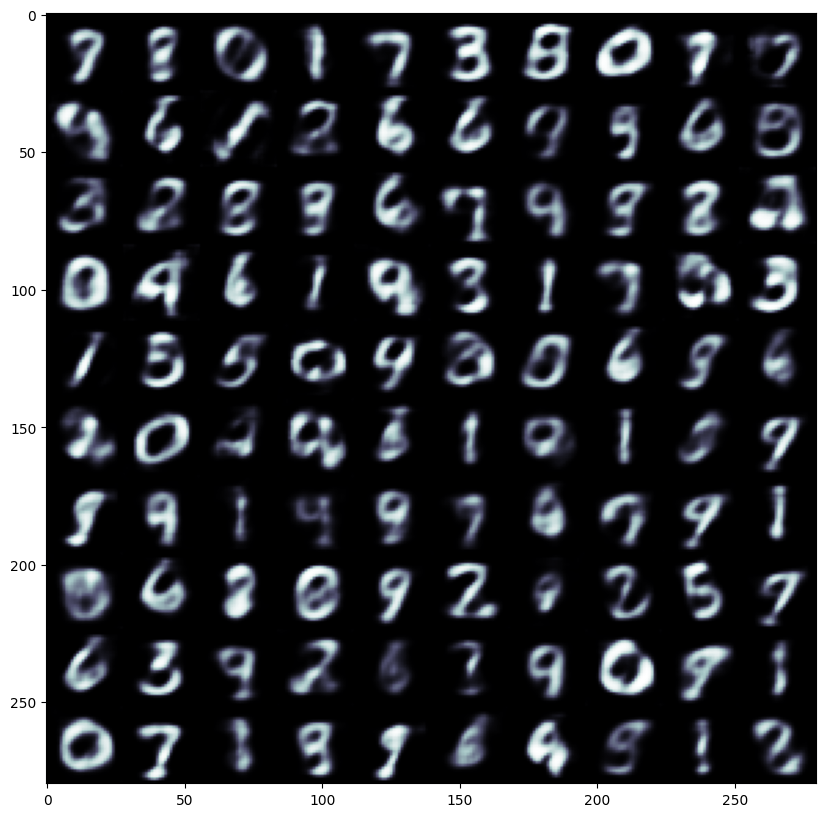

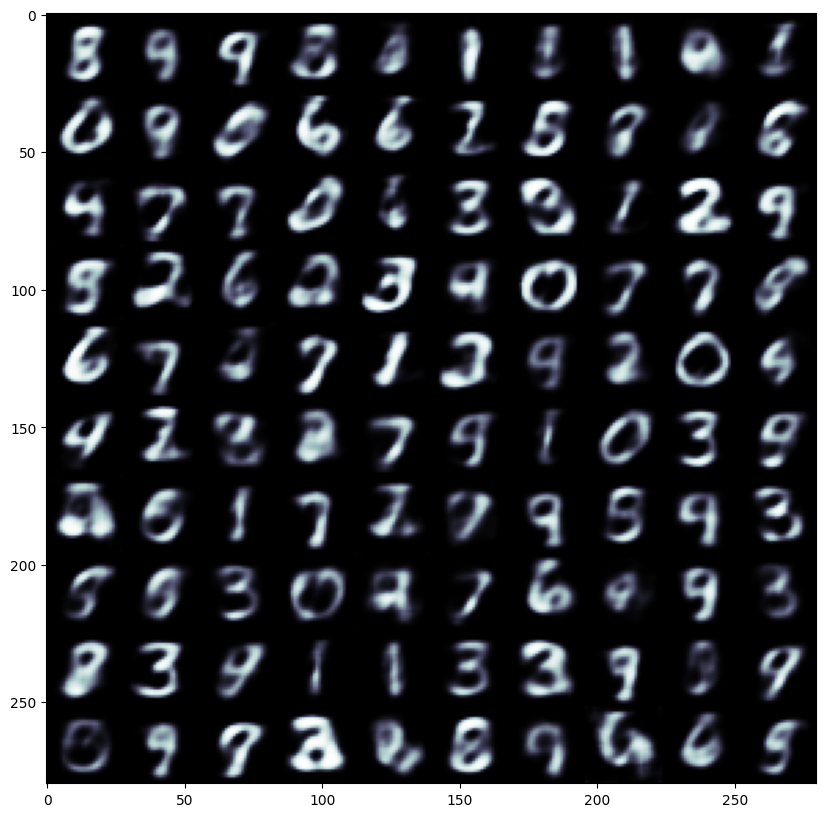

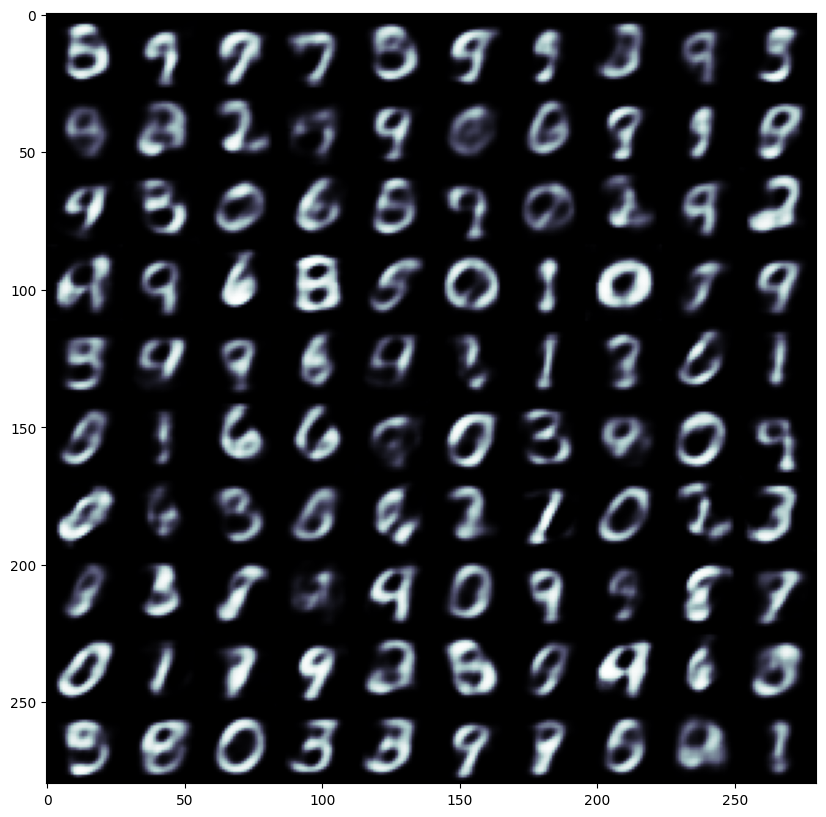

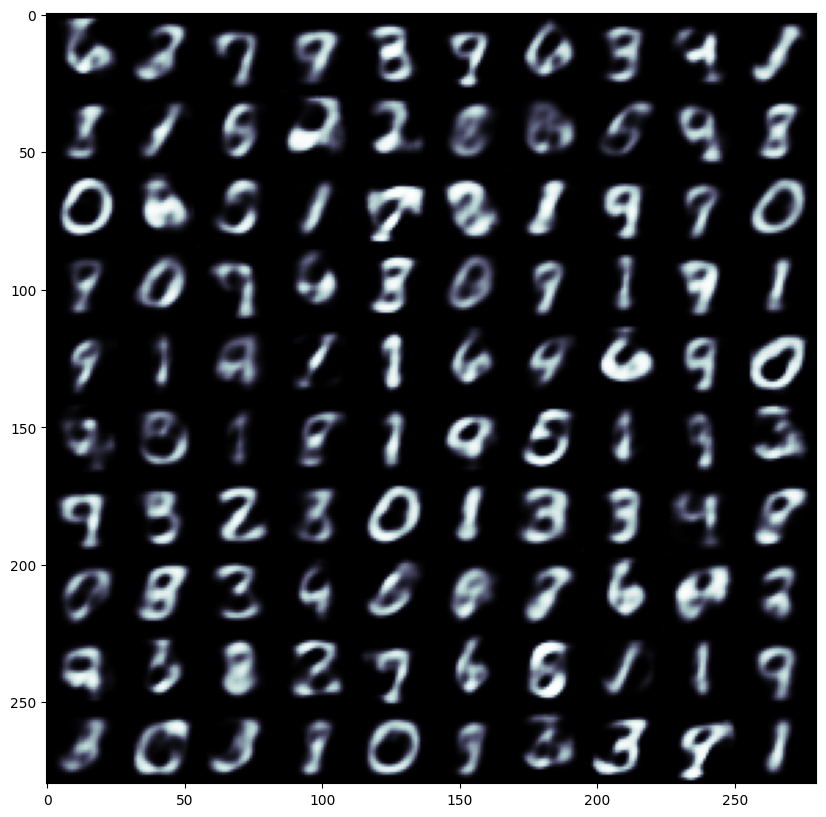

KeyboardInterrupt: 

In [8]:
######Setting all the hyperparameters
##You can change them if you want

iters = 200
num_latent = 50
print_every = 20    #print after every 5 iterations
model = Net(num_latent)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=2e-3)

train(trainloader, iters, model, device, optimizer, print_every)